In [1]:
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web # type: ignore
from datetime import datetime
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt


/Users/yash/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [16]:
# Define Yahoo Finance tickers
yahoo_tickers = {
    "S&P 500": "^GSPC",
    "Oil Price": "CL=F",
    "Gold Price": "GC=F"
}

# Set date range
start_date = "2025-01-13"
end_date = "2025-03-16"

# Download Yahoo Finance data
market_data = yf.download(list(yahoo_tickers.values()), start=start_date, end=end_date)

# Rename columns
market_data = market_data["Close"].rename(columns=dict(zip(yahoo_tickers.values(), yahoo_tickers.keys())))


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


In [17]:
# Define FRED tickers
fred_tickers = {
    "2Y Treasury Yield": "DGS2",
    "10Y Treasury Yield": "DGS10",
    "Break-even Inflation": "T10YIE",
    "BBB Yield Spread": "BAMLC0A4CBBBEY",
    "High-yield Spread": "BAMLH0A0HYM2EY",
    "US Dollar Index": "DTWEXBGS"

}

# Download data from FRED
fred_data = web.DataReader(list(fred_tickers.values()), "fred", start_date, end_date)

# Rename columns
fred_data = fred_data.rename(columns=fred_tickers)


In [18]:
# Merge Yahoo and FRED datasets
full_data = market_data.merge(fred_data, left_index=True, right_index=True, how="outer")
#full_data.to_csv("FRM_data.csv")

In [2]:
# Load the tariff events CSV  
tariff_df = pd.read_excel("trump_tariff_events_2025.xlsx", parse_dates=['Date'],index_col="Date")  
tariff_df.head()

,Event,Tariff Impact
Date,,
2025-01-21,Trump announces 25% tariffs on imports from Ca...,Increased
2025-02-03,Trump pauses Mexico & Canada tariffs for 30 da...,Decreased
2025-02-04,10% tariffs on Chinese imports take effect; Ch...,Increased
2025-02-10,Trump reintroduces 25% tariffs on foreign stee...,Increased
2025-02-13,Trump proposes broad reciprocal tariffs to pus...,Increased


In [31]:
price_df = pd.read_csv("FRM_data.csv",parse_dates=['Date'] ,index_col="Date")
price_df.head()

/var/folders/5j/c6s82_kj0fl5qzp5hvp084500000gn/T/ipykernel_13020/3980862002.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  price_df = pd.read_csv("FRM_data.csv",parse_dates=['Date'] ,index_col="Date")


,Oil Price,Gold Price,S&P 500,DGS2,DGS10,T10YIE,BAMLC0A4CBBBEY,BAMLH0A0HYM2EY,DTWEXBGS
Date,,,,,,,,,
2025-01-13,78.820000,2673.500000,5836.220215,4.40,4.79,2.45,5.75,7.43,130.2142
2025-01-14,77.500000,2677.500000,5842.910156,4.37,4.78,2.44,5.73,7.34,129.5812
2025-01-15,80.040001,2712.500000,5949.910156,4.27,4.66,2.42,5.60,7.13,129.4107
2025-01-16,78.680000,2746.399902,5937.339844,4.23,4.61,2.42,5.56,7.10,129.6284
2025-01-17,77.879997,2744.300049,5996.660156,4.27,4.61,2.41,5.57,7.03,129.6771


In [32]:
transformed = pd.DataFrame(index=price_df.index)

price_cols = ["Oil Price", "Gold Price", "S&P 500", "DTWEXBGS"]
for col in price_cols:
    transformed[col] = price_df[col].pct_change()*100

diff_cols = ["DGS2", "DGS10", "T10YIE", "BAMLC0A4CBBBEY", "BAMLH0A0HYM2EY"]
for col in diff_cols:
    transformed[col] = price_df[col].diff()  # First differences

# Drop rows with NaNs (from differencing)
transformed.dropna(inplace=True)
transformed.head()


,Oil Price,Gold Price,S&P 500,DTWEXBGS,DGS2,DGS10,T10YIE,BAMLC0A4CBBBEY,BAMLH0A0HYM2EY
Date,,,,,,,,,
2025-01-14,-1.674701,0.149617,0.114628,-0.486122,-0.03,-0.01,-0.01,-0.02,-0.09
2025-01-15,3.277421,1.307190,1.831279,-0.131578,-0.10,-0.12,-0.02,-0.13,-0.21
2025-01-16,-1.699151,1.249766,-0.211269,0.168224,-0.04,-0.05,0.00,-0.04,-0.03
2025-01-17,-1.016781,-0.076458,0.999106,0.037569,0.04,0.00,-0.01,0.01,-0.07
2025-01-21,-2.555210,0.389897,0.876823,-0.822890,0.02,-0.04,-0.03,-0.04,-0.06


In [33]:
price_df = transformed
price_df.head()

,Oil Price,Gold Price,S&P 500,DTWEXBGS,DGS2,DGS10,T10YIE,BAMLC0A4CBBBEY,BAMLH0A0HYM2EY
Date,,,,,,,,,
2025-01-14,-1.674701,0.149617,0.114628,-0.486122,-0.03,-0.01,-0.01,-0.02,-0.09
2025-01-15,3.277421,1.307190,1.831279,-0.131578,-0.10,-0.12,-0.02,-0.13,-0.21
2025-01-16,-1.699151,1.249766,-0.211269,0.168224,-0.04,-0.05,0.00,-0.04,-0.03
2025-01-17,-1.016781,-0.076458,0.999106,0.037569,0.04,0.00,-0.01,0.01,-0.07
2025-01-21,-2.555210,0.389897,0.876823,-0.822890,0.02,-0.04,-0.03,-0.04,-0.06


In [34]:
price_df["Tariff Impact"] = "Normal"
for event_date, row in tariff_df.iterrows():
    # If the event_date is in the price_df index, assign its tariff impact.
    if event_date in price_df.index:
        price_df.loc[event_date, "Tariff Impact"] = row["Tariff Impact"]

price_df.sort_index(inplace=True)
price_df.head()

,Oil Price,Gold Price,S&P 500,DTWEXBGS,DGS2,DGS10,T10YIE,BAMLC0A4CBBBEY,BAMLH0A0HYM2EY,Tariff Impact
Date,,,,,,,,,,
2025-01-14,-1.674701,0.149617,0.114628,-0.486122,-0.03,-0.01,-0.01,-0.02,-0.09,Normal
2025-01-15,3.277421,1.307190,1.831279,-0.131578,-0.10,-0.12,-0.02,-0.13,-0.21,Normal
2025-01-16,-1.699151,1.249766,-0.211269,0.168224,-0.04,-0.05,0.00,-0.04,-0.03,Normal
2025-01-17,-1.016781,-0.076458,0.999106,0.037569,0.04,0.00,-0.01,0.01,-0.07,Normal
2025-01-21,-2.555210,0.389897,0.876823,-0.822890,0.02,-0.04,-0.03,-0.04,-0.06,Increased


In [35]:
price_df

,Oil Price,Gold Price,S&P 500,DTWEXBGS,DGS2,DGS10,T10YIE,BAMLC0A4CBBBEY,BAMLH0A0HYM2EY,Tariff Impact
Date,,,,,,,,,,
2025-01-14,-1.674701,0.149617,0.114628,-0.486122,-0.03,-0.01,-0.01,-0.02,-0.09,Normal
2025-01-15,3.277421,1.307190,1.831279,-0.131578,-0.10,-0.12,-0.02,-0.13,-0.21,Normal
2025-01-16,-1.699151,1.249766,-0.211269,0.168224,-0.04,-0.05,0.00,-0.04,-0.03,Normal
2025-01-17,-1.016781,-0.076458,0.999106,0.037569,0.04,0.00,-0.01,0.01,-0.07,Normal
2025-01-21,-2.555210,0.389897,0.876823,-0.822890,0.02,-0.04,-0.03,-0.04,-0.06,Increased
2025-01-22,-0.592959,0.457354,0.613794,-0.052251,0.00,0.03,0.02,0.02,0.01,Normal
2025-01-23,-1.086956,-0.162596,0.531349,-0.084952,0.00,0.05,0.02,0.02,0.04,Normal
2025-01-24,0.053606,0.513914,-0.285513,-0.584193,-0.02,-0.02,0.01,-0.03,-0.04,Normal
2025-01-27,-1.995721,-1.433048,-1.458072,0.471714,-0.10,-0.10,-0.03,-0.07,-0.01,Normal


In [36]:
def rigobon_estimator(cov_high, cov_low, var1, var2):
    numerator = cov_high.loc[var1, var2] / cov_high.loc[var2, var2] - cov_low.loc[var1, var2] / cov_low.loc[var2, var2]
    denominator = cov_high.loc[var1, var1] / cov_high.loc[var2, var2] - cov_low.loc[var1, var1] / cov_low.loc[var2, var2]
    return numerator / denominator

In [37]:
high_volatility_dates = tariff_df.index
normal_volatility_dates = price_df.index.difference(high_volatility_dates)

In [38]:
cov_high = price_df.loc[high_volatility_dates].iloc[:, :-1].cov()
cov_low = price_df.loc[normal_volatility_dates].iloc[:, :-1].cov()

In [39]:
# Estimate impact of tariffs on various financial variables
base_var = 'DGS2'  # 2Y Treasury yield as base variable
impacts = {}

In [40]:
for var in price_df.columns:
    if var != base_var and var != 'Tariff Impact':
        impact = rigobon_estimator(cov_high, cov_low, base_var, var)
        impacts[var] = impact

In [48]:
# Print results
print("Estimated impacts of tariff risk ( to 25 bps  drop in 2Y Treasury yield):")
for var, impact in impacts.items():
    price_cols = ["Oil Price", "Gold Price", "S&P 500", "DTWEXBGS"]
    if var in price_cols:
        print(f"Impact on {var}: {impact * -0.25:.3f}%")
    else:    
        print(f"Impact on {var}: {impact * -0.25:.3f}bps")

Estimated impacts of tariff risk ( to 25 bps  drop in 2Y Treasury yield):
Impact on Oil Price: 2.931%
Impact on Gold Price: 0.695%
Impact on S&P 500: 0.703%
Impact on DTWEXBGS: -0.060%
Impact on DGS10: -0.704bps
Impact on T10YIE: 0.014bps
Impact on BAMLC0A4CBBBEY: -0.857bps
Impact on BAMLH0A0HYM2EY: -0.516bps


In [49]:
# Calculate variances for different regimes
var_normal = price_df[price_df['Tariff Impact'] == 'Normal'].iloc[:, :-1].var()
var_increased = price_df[price_df['Tariff Impact'].isin(["Increased", "Decreased"])].iloc[:, :-1].var()

In [50]:
# Calculate variance changes and predicted changes
var_diff = var_increased - var_normal
#pred_change = {var: (impact )**2 * var_diff[base_var] for var, impact in impacts.items()}
pred_change = var_diff


In [52]:
#pct_explained = {var: pred_change[var] / var_diff[var] * 100 for var in pred_change}
pct_explained = pred_change * 100 /var_increased

In [53]:
# Create results table
results = pd.DataFrame({
    'Var. on Normal days': var_normal,
    'Var. on Increased days': var_increased,
    'Predicted Change in Var.': pred_change,
    '% Explained': pct_explained,
    'Var. on all days': price_df.iloc[:, :-1].var()
})

# Display results
print("\nVariance Analysis:")
results


Variance Analysis:


,Var. on Normal days,Var. on Increased days,Predicted Change in Var.,% Explained,Var. on all days
Oil Price,2.154358,2.942370,0.788011,26.781520,2.358777
Gold Price,0.906523,0.560310,-0.346212,-61.789407,0.807097
S&P 500,0.860925,1.642939,0.782013,47.598444,1.118708
DTWEXBGS,0.072232,0.260149,0.187917,72.234373,0.128014
DGS2,0.002611,0.002592,-0.000018,-0.705296,0.002545
DGS10,0.003140,0.003360,0.000220,6.557682,0.003149
T10YIE,0.000351,0.000427,0.000076,17.844939,0.000365
BAMLC0A4CBBBEY,0.002092,0.002150,0.000058,2.680719,0.002083
BAMLH0A0HYM2EY,0.003997,0.005691,0.001694,29.765835,0.004834


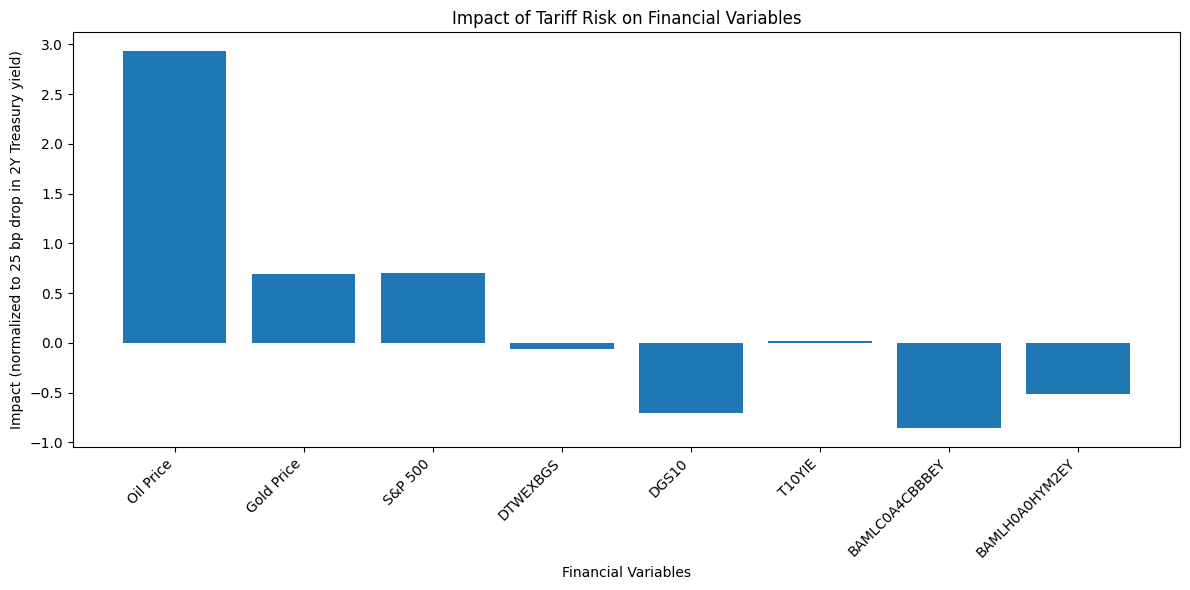

In [54]:
# Plot results
plt.figure(figsize=(12, 6))
plt.bar(impacts.keys(), [impact * -0.25 for impact in impacts.values()])
plt.title("Impact of Tariff Risk on Financial Variables")
plt.xlabel("Financial Variables")
plt.ylabel("Impact (normalized to 25 bp drop in 2Y Treasury yield)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()